# Lecture 10A — Notebook 10A.0: Recording Queue, and Selections

**Purpose:** Create a repeatable project + manifest workflow for cepstrum labs. Record multiple clips, import wavs, and store multiple named selections (time ranges) per clip.

This notebook follows the **EE519 hands-on protocol** (Lectures 7–8): manifest workflow, micro-checkpoints, debugging hints, saved figures, and reflection wrap-up.


## What you will produce in this notebook
- A project folder `EE519_L10A_Project/`
- A `manifest.json` that lists your clips
- Named selections per clip (e.g., `vowel_mid`, `fricative_mid`, `sentence_voiced`) that later notebooks will reuse


In [1]:
import os, json, math, re
from pathlib import Path

import numpy as np
import scipy.signal as sig
import scipy.fft as fft
import matplotlib.pyplot as plt

# Optional: recording in notebook
try:
    import sounddevice as sd
    HAS_SD = True
except Exception as e:
    HAS_SD = False
    print("sounddevice not available (recording disabled).", e)

# Optional: playback in notebook
try:
    from IPython.display import Audio, display
    HAS_IPY_AUDIO = True
except Exception:
    HAS_IPY_AUDIO = False

# ---------- Project paths ----------
PROJECT_ROOT = Path.cwd() / "EE519_L10A_Project"
REC_DIR = PROJECT_ROOT / "recordings"
FIG_DIR = PROJECT_ROOT / "figures"
MANIFEST_PATH = PROJECT_ROOT / "manifest.json"

for d in [REC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def load_manifest(path=MANIFEST_PATH):
    if path.exists():
        return json.loads(path.read_text())
    return {"course":"EE519","lecture":"10A","created_utc":None,"clips":[]}

def save_manifest(manifest, path=MANIFEST_PATH):
    if manifest.get("created_utc") is None:
        manifest["created_utc"] = str(np.datetime64("now"))
    path.write_text(json.dumps(manifest, indent=2))
    print("Saved manifest:", path)

manifest = load_manifest()

def save_fig(fig, name, dpi=150):
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)
    return out

# ---------- WAV I/O ----------
import wave
def write_wav(path: Path, x: np.ndarray, fs: int):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)
    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(fs)
        wf.writeframes(x_i16.tobytes())

def read_wav(path: Path):
    with wave.open(str(path), "rb") as wf:
        fs = wf.getframerate()
        n = wf.getnframes()
        x = np.frombuffer(wf.readframes(n), dtype=np.int16).astype(np.float32) / 32768.0
    return fs, x

def peak_normalize(x, target=0.98):
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * target

def play_audio(x, fs, label="audio"):
    if not HAS_IPY_AUDIO:
        print("(Audio playback not available)", label)
        return
    display(Audio(x, rate=fs))

def record_clip(seconds=2.0, fs=16000):
    if not HAS_SD:
        raise RuntimeError("sounddevice not available. Load wav files instead.")
    print(f"Recording {seconds:.1f}s @ {fs} Hz ...")
    x = sd.rec(int(seconds*fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()
    return fs, x.squeeze()

def add_clip_to_manifest(filename, label, fs, notes=""):
    clip = {
        "filename": filename,
        "label": label,
        "fs": int(fs),
        "notes": notes,
        "added_utc": str(np.datetime64("now")),
        "selections": {}
    }
    manifest["clips"].append(clip)
    save_manifest(manifest)
    return len(manifest["clips"]) - 1

def list_clips():
    for i,c in enumerate(manifest["clips"]):
        print(f"[{i}] {c['label']:12s}  {c['filename']}  fs={c['fs']}  notes={c.get('notes','')}")

# ---------- Framing helpers ----------
def frame_signal(x, N, H):
    if len(x) < N:
        x = np.pad(x, (0, N-len(x)))
    num = 1 + (len(x) - N)//H
    idx = np.arange(N)[None,:] + H*np.arange(num)[:,None]
    return x[idx]

def seconds_to_samples(t0, t1, fs, xlen):
    s0 = int(max(0, round(t0*fs)))
    s1 = int(min(xlen, round(t1*fs)))
    if s1 <= s0:
        raise ValueError("Bad selection: t1 must be > t0")
    return s0, s1

def samples_to_frame_range(s0, s1, N, H, xlen):
    f0 = max(0, int((s0 - N)//H) + 1)
    f1 = min(int((s1)//H), int((xlen-N)//H))
    if f1 < f0:
        f0 = max(0, int(s0//H))
        f1 = min(int((xlen-N)//H), f0)
    return f0, f1

def db(x):
    return 20*np.log10(np.maximum(x, 1e-12))

print("Project root:", PROJECT_ROOT)
print("Clips in manifest:", len(manifest["clips"]))


Project root: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project
Clips in manifest: 0


## 1) Recording queue (recommended in class)

Record multiple clips separately. Suggested filenames are automatically created.

**Targets**
- `vowel_a` (steady /a/)
- `vowel_i` (steady /i/)
- `vowel_u` (steady /u/)
- `fricative_s` (steady /s/)
- `sentence` (short sentence)

If recording isn't available, skip ahead to **Import WAVs**.


In [7]:
DO_RECORD = True  # set True in class

TARGETS = [
    ("vowel_a", 2.0, "steady /a/"),
    ("vowel_i", 2.0, "steady /i/"),
    ("vowel_u", 2.0, "steady /u/"),
    ("fricative_s", 2.0, "steady /s/"),
    ("sentence", 3.0, "short sentence"),
]

if DO_RECORD:
    for label, seconds, notes in TARGETS:
        fs, x = record_clip(seconds=seconds, fs=16000)
        x = peak_normalize(x)
        fname = f"student_{label}.wav"
        write_wav(REC_DIR/fname, x, fs)
        add_clip_to_manifest(fname, label=label, fs=fs, notes=notes)
        print("Recorded:", fname)
        play_audio(x, fs, label)
else:
    print("Skipping recording (set DO_RECORD=True).")


Recording 2.0s @ 16000 Hz ...
Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
Recorded: student_vowel_a.wav


Recording 2.0s @ 16000 Hz ...
Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
Recorded: student_vowel_i.wav


Recording 2.0s @ 16000 Hz ...
Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
Recorded: student_vowel_u.wav


Recording 2.0s @ 16000 Hz ...
Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
Recorded: student_fricative_s.wav


Recording 3.0s @ 16000 Hz ...
Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
Recorded: student_sentence.wav


## 2) Import WAV files (fallback)

Drop WAV files into `EE519_L10A_Project/recordings/` and run the next cell.


In [8]:
existing = set([c["filename"] for c in manifest["clips"]])
wav_files = sorted([p.name for p in REC_DIR.glob("*.wav")])
added = 0
for wf in wav_files:
    if wf not in existing:
        fs, _ = read_wav(REC_DIR/wf)
        add_clip_to_manifest(wf, label="imported", fs=fs, notes="auto-import")
        added += 1

print("WAV files:", wav_files)
print("Newly added:", added)
print("Total clips:", len(manifest["clips"]))


WAV files: ['student_fricative_s.wav', 'student_sentence.wav', 'student_vowel_a.wav', 'student_vowel_i.wav', 'student_vowel_u.wav']
Newly added: 0
Total clips: 19


## 3) Create named selections (time ranges) per clip

You will reuse these names in later notebooks. Examples:
- `vowel_mid` (middle steady vowel)
- `fricative_mid` (middle steady fricative)
- `sentence_voiced` (voiced region inside sentence)

We store them under:
`clip["selections"]["analysis_segments"][segment_name]`


In [14]:
list_clips()
CLIP_IDX = 4  # choose clip index
clip = manifest["clips"][CLIP_IDX]
fs, x = read_wav(REC_DIR / clip["filename"])
x = peak_normalize(x)

print("Selected:", CLIP_IDX, clip["label"], clip["filename"], "fs=", fs, "len_sec=", len(x)/fs)
play_audio(x, fs, clip["label"])


[0] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[1] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[2] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[3] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[4] sentence      student_sentence.wav  fs=16000  notes=short sentence
[5] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[6] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[7] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[8] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[9] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[10] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[11] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[12] sentence      student_sentence.wav  fs=16000  notes=short sentence
[13] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[14] vowel_a       student_vowel_a.wav  fs=16000  note

In [15]:
# Frame params used in later notebooks (store them with the segment)
WIN_MS, HOP_MS = 25, 10
N = int(WIN_MS*1e-3*fs)
H = int(HOP_MS*1e-3*fs)

segment_name = "sentence_mid"   # e.g., "vowel_mid"
t0, t1 = 1.0, 1.5     # seconds; adjust in class

s0, s1 = seconds_to_samples(t0, t1, fs, len(x))
f0, f1 = samples_to_frame_range(s0, s1, N, H, len(x))

clip = manifest["clips"][CLIP_IDX]
clip.setdefault("selections", {}).setdefault("analysis_segments", {})
clip["selections"]["analysis_segments"][segment_name] = {
    "t0": float(t0), "t1": float(t1),
    "s0": int(s0), "s1": int(s1),
    "win_ms": float(WIN_MS), "hop_ms": float(HOP_MS),
    "N": int(N), "H": int(H),
    "frame_range": [int(f0), int(f1)]
}
manifest["clips"][CLIP_IDX] = clip
save_manifest(manifest)

print("Stored selection:", segment_name, "frames", (f0, f1))


Saved manifest: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\manifest.json
Stored selection: sentence_mid frames (98, 150)


### Plot waveform + selection (save to figures/)


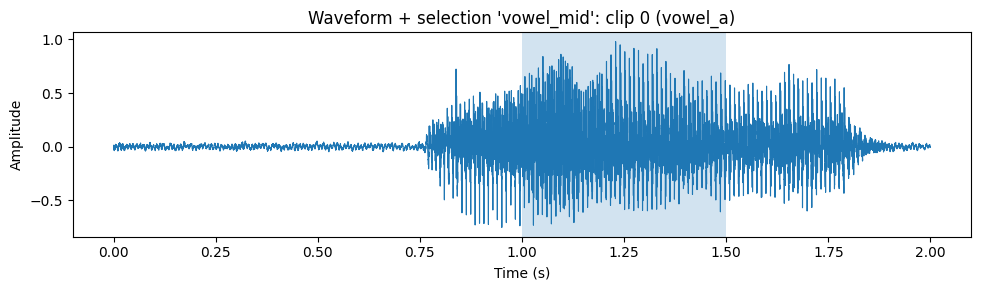

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\sel_clip0_vowel_mid.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/sel_clip0_vowel_mid.png')

In [13]:
t = np.arange(len(x))/fs
fig = plt.figure(figsize=(10,3))
plt.plot(t, x, linewidth=0.8)
plt.axvspan(t0, t1, alpha=0.2)
plt.title(f"Waveform + selection '{segment_name}': clip {CLIP_IDX} ({clip['label']})")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.tight_layout(); plt.show()

save_fig(fig, f"sel_clip{CLIP_IDX}_{re.sub(r'[^a-zA-Z0-9_]+','_',segment_name)}.png")


## Wrap-up
**What you learned:** how to create reproducible clip + selection metadata in the manifest.  
**What's next:** Notebook 10A.1 computes cepstrum on a chosen frame inside a selection.


## Reflection questions
1. How does your selection quality affect later analysis (cepstrum/LPC/STFT)?  
2. Which clip types are most “stationary” for short-time modeling and why?  
3. What is your plan for naming segments so you can re-use them across notebooks?


### Answers

1. The less noise and the more we isolated the reproducible part then we will have an easier time interpretting the analysis later.
2. The vowel sounds are the most stationary since our vocal folds are constant compared to full sentences.
3. I will try to use even number to remember and keep track of the segments.